In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from featureExtraction import extract_grasp_polygons_over_time
from tqdm import tqdm
from typing import Optional, List, Tuple, Dict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [45]:
df = pd.read_csv("processed/user0/User0_TransformLog_SmallCube_Grasp_config3.csv")
features= extract_grasp_polygons_over_time(df)
print(features.shape)
print(features)


(161, 31)
     Timestamp  tip_edge0_x  tip_edge0_y  tip_edge0_z  tip_edge1_x  \
0        37.63         4.96        -0.57         6.19         2.60   
1        37.64         4.96        -0.57         6.18         2.59   
2        37.65         4.96        -0.55         6.19         2.59   
3        37.67         4.96        -0.55         6.19         2.59   
4        37.68         4.96        -0.54         6.19         2.60   
..         ...          ...          ...          ...          ...   
156      39.82         5.78         0.34         4.38         1.85   
157      39.84         5.76         0.27         4.44         1.83   
158      39.85         5.73        -0.13         4.33         1.74   
159      39.86         5.72        -0.41         4.12         1.64   
160      39.88         5.78        -0.62         3.88         1.49   

     tip_edge1_y  tip_edge1_z  tip_edge2_x  tip_edge2_y  tip_edge2_z  ...  \
0          -0.13         0.75         1.98         0.04        -1.40  ..

features shape meaning:

| `197`     | Rows    | We have **197 timestamps (frames)** — i.e., 197 moments during this one grasp trial where features were extracted.

| `31`      | Columns | We have **31 features per frame**: 30 edge vector features + 1 timestamp.      


## Random Forest Object Classification

In [46]:
def prepare_trial(transform_log_path: str, duration: float = 3.0, timestep: float = 0.01) -> pd.DataFrame:
    """
    Loads a raw transform log, extracts polygon features, and pads to last 3 seconds.

    Args:
        transform_log_path (str): Path to raw transform log CSV.
        duration (float): Duration before contact to retain (default: 3.0s).
        timestep (float): Assumed sampling rate (e.g. 0.01s = 100Hz)

    Returns:
        pd.DataFrame: Shape (T, 30) of polygon edge features, padded if needed.
    """
    raw_df = pd.read_csv(transform_log_path)
    if raw_df.empty or "Timestamp" not in raw_df.columns or "Name" not in raw_df.columns:
        raise ValueError(f"File {transform_log_path} is malformed or empty.")

    # Extract polygon features
    features_df = extract_grasp_polygons_over_time(raw_df)
    if features_df.empty:
        raise ValueError(f"No valid polygon features could be extracted from {transform_log_path}")

    # Identify contact moment (last timestamp)
    contact_time = features_df["Timestamp"].max()
    start_time = contact_time - duration

    # Trim to desired window before contact
    trial_window = features_df[(features_df["Timestamp"] >= start_time) & (features_df["Timestamp"] <= contact_time)].copy()

    # Drop timestamp column
    trial_window = trial_window.drop(columns=["Timestamp"])
    # Keep Timestamp column during slicing
    trial_window = features_df[(features_df["Timestamp"] >= start_time) & (features_df["Timestamp"] <= contact_time)].copy()

    # Pad if necessary
    expected_steps = int(duration / timestep)
    if len(trial_window) < expected_steps:
        pad_rows = expected_steps - len(trial_window)
        pad_data = pd.DataFrame(np.zeros((pad_rows, trial_window.shape[1])), columns=trial_window.columns)
        trial_window = pd.concat([pad_data, trial_window], ignore_index=True)
    elif len(trial_window) > expected_steps:
        trial_window = trial_window.iloc[-expected_steps:]

    return trial_window



In [47]:
trial_df = prepare_trial("processed/user0/User0_TransformLog_SmallCube_Grasp_config3.csv")
print(trial_df.shape)  # (300, 30)
print(trial_df)


(300, 31)
     Timestamp  tip_edge0_x  tip_edge0_y  tip_edge0_z  tip_edge1_x  \
0         0.00         0.00         0.00         0.00         0.00   
1         0.00         0.00         0.00         0.00         0.00   
2         0.00         0.00         0.00         0.00         0.00   
3         0.00         0.00         0.00         0.00         0.00   
4         0.00         0.00         0.00         0.00         0.00   
..         ...          ...          ...          ...          ...   
295      39.82         5.78         0.34         4.38         1.85   
296      39.84         5.76         0.27         4.44         1.83   
297      39.85         5.73        -0.13         4.33         1.74   
298      39.86         5.72        -0.41         4.12         1.64   
299      39.88         5.78        -0.62         3.88         1.49   

     tip_edge1_y  tip_edge1_z  tip_edge2_x  tip_edge2_y  tip_edge2_z  ...  \
0           0.00         0.00         0.00         0.00         0.00  ..

In [99]:
# === MAIN FUNCTION ===
from collections import Counter

def load_dataset_from_trials(interval, label, DATA_ROOT, USERS, OBJECTS, TASKS):
    X, y = [], []

    for user in USERS:
        user_path = os.path.join(DATA_ROOT, user)
        if not os.path.isdir(user_path):
            continue

        for file in os.listdir(user_path):
            if not file.endswith(".csv") or "TransformLog" not in file:
                continue

            parts = file.split("_")
            if len(parts) < 5:
                continue

            object_name = parts[2]
            task_name = parts[3]
            if object_name not in OBJECTS or task_name not in TASKS:
                continue

            path = os.path.join(user_path, file)
            try:
                trial = prepare_trial(path).iloc[:interval]  # (300, 30)
                features = trial.to_numpy().flatten()  # Shape (9000,)
                X.append(features)
                if label == "object":
                    y.append(object_name)
                elif label == "task":
                    y.append(task_name)
                
            except Exception as e:
                print(f"⚠️ Skipping {file}: {e}")
                continue
        # After collecting all labels
    label_counts = Counter(y)
    print("📊 Object counts in dataset:")
    for obj, count in label_counts.items():
        print(f"   {obj}: {count}")

# Print total count
    print(f"\n🔢 Total trials loaded: {len(y)}")
    return np.array(X), np.array(y)   



In [93]:
# === TRAINING & EVALUATION ===
import pickle

def evaluate_intervals(
    intervals: List[int],
    label: str,
    data_root: str,
    users: List[str],
    objects: List[str],
    tasks: List[str],
    save_path: str 
) -> List[Tuple[int, float, List[str], List[str]]]:
    """
    Trains and evaluates a RandomForest on different interval lengths and saves results.

    Returns:
        A list of tuples: (interval_step, accuracy, y_test, y_pred)
    """
    results = []

    for interval in intervals:
        print(f"\n⏱️ Evaluating with interval: {3 - (interval * 0.01):.2f} seconds before contact...")

        X, y = load_dataset_from_trials(interval, label, data_root, users, objects, tasks)

        if len(X) == 0:
            print(f"❌ No data loaded for interval {interval}, skipping.")
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        results.append((interval, acc, y_test, y_pred))

        print(f"\n✅ Accuracy: {acc:.3f}")
        print("\n📊 Classification Report:")
        print(classification_report(y_test, y_pred))

    # Save results
    with open(save_path, "wb") as f:
        pickle.dump(results, f)

    print(f"\n✅ interval_accuracies saved to '{save_path}'")

    return results


In [96]:
def evaluate_single_interval(
    interval_step: int,
    label: str,
    data_root: str,
    users: List[str],
    objects: List[str],
    tasks: List[str],
    verbose: bool = True
) -> Tuple[float, List[str], List[str]]:
    """
    Trains and evaluates a RandomForest classifier for a single time interval.

    Args:
        interval_step (int): Number of rows to include (e.g., 150 for last 1.5s).
        data_root (str): Path to data folder.
        users (List[str]): List of user folder names to include.
        objects (List[str]): List of object labels to include.
        tasks (List[str]): List of task types to include.
        verbose (bool): Whether to print accuracy and classification report.

    Returns:
        Tuple: (accuracy, y_test, y_pred)
    """
    X, y = load_dataset_from_trials(interval_step, label, data_root, users, objects, tasks)

    if len(X) == 0:
        raise RuntimeError(f"❌ No data found for interval {interval_step}.")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    if verbose:
        print(f"\n✅ Interval: {interval_step} rows ({3 - interval_step * 0.01:.2f}s before contact)")
        print(f"Accuracy: {acc:.3f}")
        print("\n📊 Classification Report:")
        print(classification_report(y_test, y_pred))

    return acc, y_test, y_pred


In [113]:
def plot_confusion_matrix(y_test, y_pred, interval_step: int):
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation=60)
    plt.tight_layout()
    plt.title(f"Confusion Matrix ({3 - interval_step*0.01:.2f}s before contact)")
    plt.grid(False)
    plt.show()

## Object Classifcation with Random Forest

In [116]:
interval = 300
label= "object"  # or "object" for task classification
DATA_ROOT = "processed"
USERS = ["user0", "user2", "user3", "user4", "user5", "user6", "user7", "user8", "user9", "user10", "user11", "user12"]
OBJECTS = ["SmallCube", "MediumCube", "BigCube", "Parallelepiped", "teddy", "Mug", "CrackerBox", "Scissor", "Hammer"]
TASKS = ["Grasp", "Lift", "Push", "Pull"]
interval_accuracies = []
intervals = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]


In [118]:
results = evaluate_intervals(intervals, label, DATA_ROOT, USERS, OBJECTS, TASKS, "interval_accuracies.pkl")


⏱️ Evaluating with interval: 2.00 seconds before contact...
📊 Object counts in dataset:
   BigCube: 96
   CrackerBox: 95
   Hammer: 96
   MediumCube: 96
   Mug: 96
   Parallelepiped: 96
   Scissor: 95
   SmallCube: 96
   teddy: 96

🔢 Total trials loaded: 862

✅ Accuracy: 0.197

📊 Classification Report:
                precision    recall  f1-score   support

       BigCube       0.33      0.07      0.11        29
    CrackerBox       0.25      0.07      0.11        28
        Hammer       0.14      0.97      0.24        29
    MediumCube       0.29      0.07      0.11        29
           Mug       0.40      0.07      0.12        29
Parallelepiped       0.40      0.07      0.12        29
       Scissor       1.00      0.07      0.13        28
     SmallCube       0.38      0.17      0.24        29
         teddy       0.55      0.21      0.30        29

      accuracy                           0.20       259
     macro avg       0.42      0.20      0.17       259
  weighted avg       

KeyboardInterrupt: 

### overtime accuracy for cubes

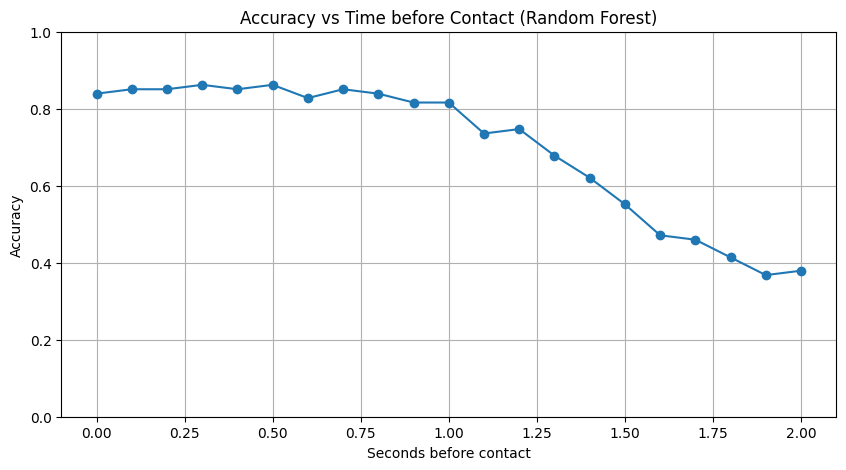

In [ ]:
# Plot
intervals, accuracies = zip(*interval_accuracies)

plt.figure(figsize=(10, 5))
plt.plot([ 3.0 - i * 0.01 for i in intervals], accuracies, marker='o')
plt.xlabel("Seconds before contact")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Time before Contact (Random Forest)")
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()


### over time accuracy for all objects

In [ ]:
# Plot
intervals, accuracies = zip(*results)

plt.figure(figsize=(10, 5))
plt.plot([ 3.0 - i * 0.01 for i in intervals], accuracies, marker='o')
plt.xlabel("Seconds before contact")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Time before Contact (Random Forest)")
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()


In [108]:
acc, y_test, y_pred = evaluate_single_interval(
    interval_step=300,
    label="object",
    data_root=DATA_ROOT,
    users=USERS,
    objects=OBJECTS,
    tasks=TASKS
)

📊 Object counts in dataset:
   BigCube: 96
   CrackerBox: 95
   Hammer: 96
   MediumCube: 96
   Mug: 96
   Parallelepiped: 96
   Scissor: 95
   SmallCube: 96
   teddy: 96

🔢 Total trials loaded: 862

✅ Interval: 300 rows (0.00s before contact)
Accuracy: 0.710

📊 Classification Report:
                precision    recall  f1-score   support

       BigCube       0.74      0.59      0.65        29
    CrackerBox       0.71      0.61      0.65        28
        Hammer       0.73      0.93      0.82        29
    MediumCube       0.74      0.79      0.77        29
           Mug       0.73      0.66      0.69        29
Parallelepiped       0.59      0.66      0.62        29
       Scissor       0.79      0.68      0.73        28
     SmallCube       0.81      0.90      0.85        29
         teddy       0.57      0.59      0.58        29

      accuracy                           0.71       259
     macro avg       0.71      0.71      0.71       259
  weighted avg       0.71      0.71     

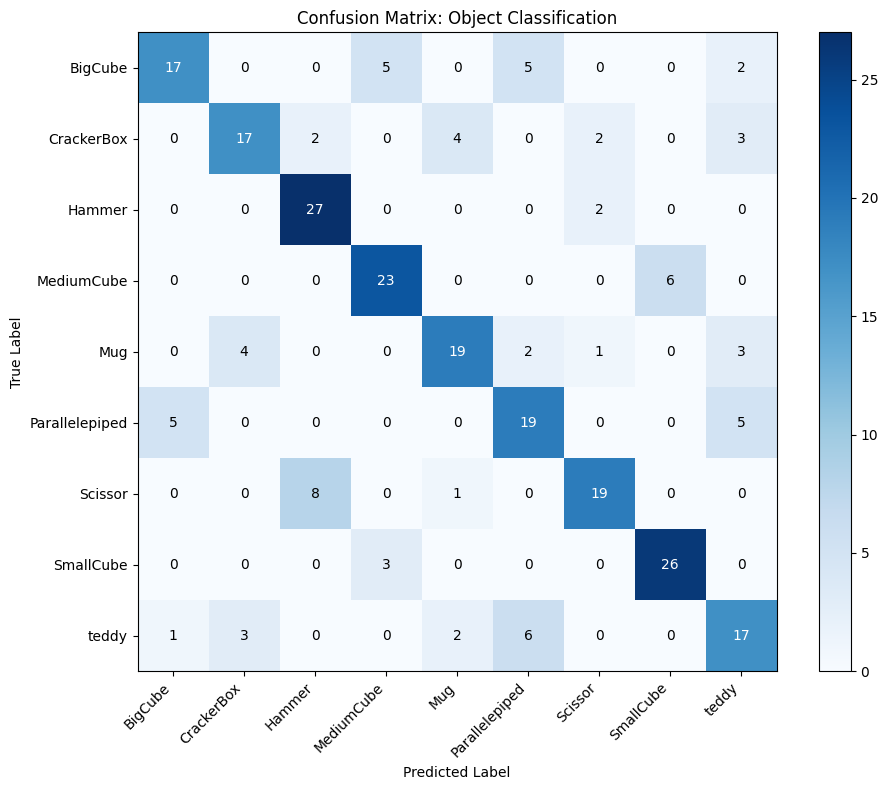

In [115]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot
plt.figure(figsize=(10, 8))
im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Object Classification")
plt.colorbar(im)

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right')
plt.yticks(tick_marks, labels)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show values in each cell
thresh = cm.max() / 2
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


## Random Forest Task Classification


In [103]:
label= "task"  # or "object" for task classification
DATA_ROOT = "processed"
USERS = ["user0", "user2", "user3", "user4", "user5", "user6", "user7", "user8", "user9", "user10", "user11", "user12"]
OBJECTS = ["SmallCube", "MediumCube", "BigCube", "Parallelepiped", "teddy", "Mug", "CrackerBox", "Scissor", "Hammer"]
TASKS = ["Lift", "Push", "Pull"]
interval_accuracies_tasks = []
intervals = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]


In [ ]:
results_task = evaluate_intervals(intervals, label, DATA_ROOT, USERS, OBJECTS, TASKS, "interval_accuracies_tasks.pkl")

In [ ]:
# Plot
intervals, accuracies = zip(*results_task)

plt.figure(figsize=(10, 5))
plt.plot([ 3.0 - i * 0.01 for i in intervals], accuracies, marker='o')
plt.xlabel("Seconds before contact")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Time before Contact (Random Forest)")
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()

In [106]:

acc_task, y_test_task, y_pred_task = evaluate_single_interval(
    interval_step=250,
    label="task",
    data_root=DATA_ROOT,
    users=USERS,
    objects=OBJECTS,
    tasks=TASKS
)

📊 Object counts in dataset:
   Lift: 216
   Pull: 214
   Push: 216

🔢 Total trials loaded: 646

✅ Interval: 250 rows (0.50s before contact)
Accuracy: 0.479

📊 Classification Report:
              precision    recall  f1-score   support

        Lift       0.46      0.55      0.50        65
        Pull       0.53      0.38      0.44        64
        Push       0.47      0.51      0.49        65

    accuracy                           0.48       194
   macro avg       0.49      0.48      0.48       194
weighted avg       0.49      0.48      0.48       194



In [ ]:
plot_confusion_matrix(y_test_task, y_pred_task, interval_step=250)

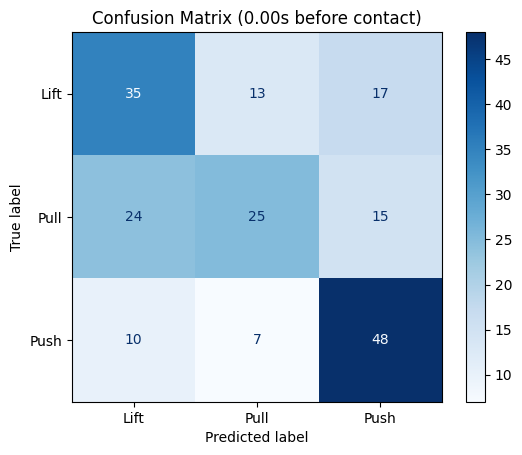

In [105]:
plot_confusion_matrix(y_test_task, y_pred_task, interval_step=300)